In [1]:
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import linregress
from elasticsearch import Elasticsearch
from sklearn.linear_model import LinearRegression

In [2]:
def get_mastodon_bom_past(date):
    url = f"http://localhost:9090/bom-mastodon/{date}"
    headers = {"X-Fission-Params-Date": date}
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        data = response.json().get('resp_dict', {})
        bom_dict = data.get('bom_dict', {})
        sentiment_dict = data.get('sentiment_dict', {})
        return {
            'Date': date,
            'average_temp': bom_dict.get('average_temp', None),
            'max_temp': bom_dict.get('max_temp', None),
            'min_temp': bom_dict.get('min_temp', None),
            'rainfall': bom_dict.get('rainfall', None),
            'wind_gust_speed': bom_dict.get('wind_gust_speed', None),
            'num_of_toots': data.get('num_of_toots', None),
            'average_sentiment': sentiment_dict.get('average_sentiment', None),
            'max_sentiment': sentiment_dict.get('max_sentiment', None),
            'min_sentiment': sentiment_dict.get('min_sentiment', None)
        }
    else:
        return {
            'Date': date,
            'average_temp': 'error',
            'max_temp': 'error',
            'min_temp': 'error',
            'rainfall': 'error',
            'wind_gust_speed': 'error',
            'num_of_toots': 'error',
            'average_sentiment': 'error',
            'max_sentiment': 'error',
            'min_sentiment': 'error'
        }


In [3]:
# create a dataframe for storing the accident data and rainfall data
dom_mastodon_past_data = []
# set date range from 2023-04-01 to 2023-09-30
date_range = pd.date_range(start='2023-05-18', end='2024-05-13')

for date in date_range:
    date_str = date.strftime('%Y-%m-%d')
    dom_mastodon_past_data.append(get_mastodon_bom_past(date_str))
     

    
dom_mastodon_past_df = pd.DataFrame(dom_mastodon_past_data)

# set date as the index
dom_mastodon_past_df.set_index('Date', inplace=True)
print(dom_mastodon_past_df.head())




            average_temp  max_temp  min_temp  rainfall  wind_gust_speed  \
Date                                                                      
2023-05-18          9.75      13.7       5.8       0.0             22.0   
2023-05-19         10.20      14.6       5.8       0.0             22.0   
2023-05-20         11.85      15.0       8.7       2.2             30.0   
2023-05-21         12.05      14.9       9.2       1.8             39.0   
2023-05-22         12.05      16.4       7.7       0.4             22.0   

            num_of_toots  average_sentiment  max_sentiment  min_sentiment  
Date                                                                       
2023-05-18             4           0.193750       0.550000       0.000000  
2023-05-19            13           0.310517       1.000000      -0.600000  
2023-05-20             9           0.049304       0.267273      -0.264196  
2023-05-21             5           0.074091       0.337500      -0.012500  
2023-05-22        

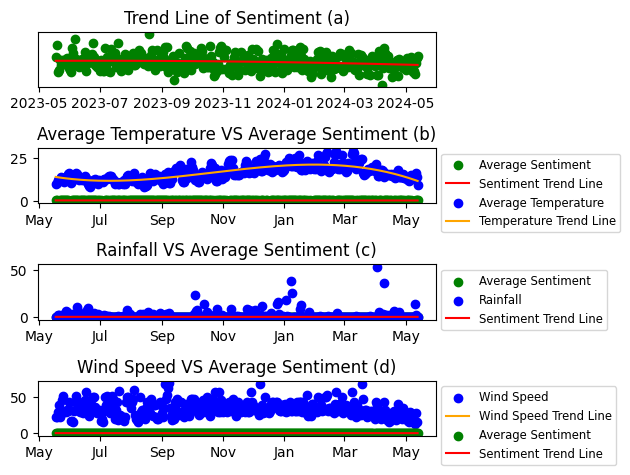

In [4]:
Date = pd.to_datetime(dom_mastodon_past_df.index)
date_ordinals = mdates.date2num(Date)
aveg_sentiment = dom_mastodon_past_df['average_sentiment']
aveg_temp = dom_mastodon_past_df['average_temp']
RainFall = dom_mastodon_past_df['rainfall']
WindSpeed = dom_mastodon_past_df['wind_gust_speed']

fig, axs = plt.subplots(4, 1)

# G1: Aveg_Sentiment VS Aveg_Temperature'
# Perform quadratic regression for the sentiment data
coefficients = np.polyfit(date_ordinals, aveg_sentiment, 2)
trend_sentiment = np.polyval(coefficients, date_ordinals)

axs[0].set_title('Trend Line of Sentiment (a)')
axs[0].plot(Date, trend_sentiment, label='Trend Line', color='red', linestyle='-')
axs[0].scatter(Date, aveg_sentiment, color='green')
axs[0].yaxis.set_ticks([])

# G2: Average Temperature VS Average Sentiment
# Perform cubic polynomial regression for the temperature data
coefficients = np.polyfit(date_ordinals, aveg_temp, 3)
trend_temp = np.polyval(coefficients, date_ordinals)

axs[1].set_title('Average Temperature VS Average Sentiment (b)')
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))

axs[1].scatter(Date, aveg_sentiment, label='Average Sentiment', color='green')
axs[1].plot(Date, trend_sentiment, label='Sentiment Trend Line', color='red', linestyle='-')

axs[1].scatter(Date, aveg_temp, label='Average Temperature', color='blue')
axs[1].plot(Date, trend_temp, label='Temperature Trend Line', color='orange', linestyle='-')
axs[1].legend(fontsize='small', loc='upper left', bbox_to_anchor=(1, 1))

# G3: Average Sentiment VS Rainfall
axs[2].set_title('Rainfall VS Average Sentiment (c)')
axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%b'))

axs[2].scatter(Date, aveg_sentiment, label='Average Sentiment', color='green')
axs[2].scatter(Date, RainFall, label='Rainfall', color='blue')

axs[2].plot(Date, trend_sentiment, label='Sentiment Trend Line', color='red', linestyle='-')
axs[2].legend(fontsize='small', loc='upper left', bbox_to_anchor=(1, 1))

# G4: Average Sentiment VS Wind Speed
coefficients = np.polyfit(date_ordinals, WindSpeed, 2)
trend_WindSpeed = np.polyval(coefficients, date_ordinals)

axs[3].set_title('Wind Speed VS Average Sentiment (d)')
axs[3].xaxis.set_major_formatter(mdates.DateFormatter('%b'))

axs[3].scatter(Date, WindSpeed, label='Wind Speed', color='blue')
axs[3].plot(Date, trend_WindSpeed, label='Wind Speed Trend Line', color='orange', linestyle='-')

axs[3].scatter(Date, aveg_sentiment, label='Average Sentiment', color='green')
axs[3].plot(Date, trend_sentiment, label='Sentiment Trend Line', color='red', linestyle='-')
axs[3].legend(fontsize='small', loc='upper left', bbox_to_anchor=(1, 1))

# Show plots
plt.tight_layout()
plt.show()

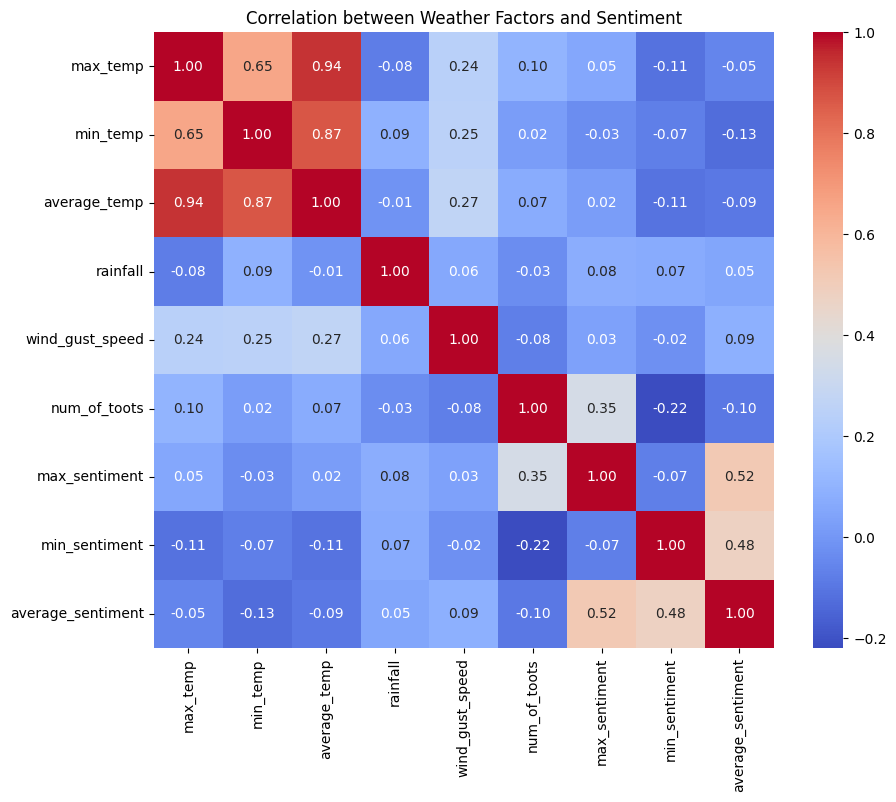

In [5]:
# heatmap
plt.figure(figsize=(10, 8))
corr = dom_mastodon_past_df[['max_temp', 'min_temp', 'average_temp', 'rainfall', 'wind_gust_speed', 'num_of_toots','max_sentiment', 'min_sentiment', 'average_sentiment']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation between Weather Factors and Sentiment')
plt.show()